In [79]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Descargar recursos de NLTK (si es la primera vez)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

%pip install gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alumno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alumno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alumno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alumno\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Note: you may need to restart the kernel to use updated packages.


In [80]:
# Cargar los datos
data = pd.read_csv("reviews_cascos_gaming.csv",sep=';', encoding="utf-8")

In [81]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import unicodedata
import re

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
snowball = SnowballStemmer('spanish')


def quitar_tildes(texto):
    texto = unicodedata.normalize("NFD", texto)  # Descomponer caracteres con tilde
    texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")  # Eliminar solo las tildes
    return unicodedata.normalize("NFC", texto)  # Recomponer texto normalizado
    
def limpiar_texto(texto):
    # Eliminar signos de puntuación y caracteres especiales
    texto = re.sub(r"[^a-zA-Z\s]", " ", texto)
    #Tiene en cuenta cuando la palabra anterior es 'no'
    texto = re.sub(r"no\s(\w+)", r"no_\1", texto)
    # Quitar tildes
    texto = quitar_tildes(texto)
    # Convertir a minúsculas
    texto = texto.lower()
    # Tokenizar palabras
    palabras = word_tokenize(texto)
    # Lematizar
    palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras] 
    # Stemming
    # palabras = [porter.stem(palabra) for palabra in word_tokenize(texto)]
    # palabras = [snowball.stem(palabra) for palabra in word_tokenize(texto)]
    # Eliminar stopwords
    palabras = [palabra for palabra in palabras if palabra not in stopwords.words("spanish")]
    return " ".join(palabras)

def sin_limpiar_texto(texto):
    return texto

data["review"] = data["review"].apply(limpiar_texto)

In [82]:
# import re
# import unicodedata
# from nltk.tokenize import word_tokenize

# # Lista de palabras ambiguas que deben ser consideradas en bigramas
# palabras_ambiguas = {"calidad", "funciona", "buena", "malo", "producto", "sonido", "precio", "recomiendo"}

# def procesar_texto_con_bigramas(texto):
#     # Quitar caracteres especiales y convertir a minúsculas
#     texto = re.sub(r"[^a-zA-Z\s]", " ", texto)
#     texto = quitar_tildes(texto).lower()
    
#     # Tokenizar palabras
#     palabras = word_tokenize(texto)
    
#     # Construir bigramas manualmente
#     bigramas = ["_".join(pair) for pair in zip(palabras, palabras[1:])]
    
#     # Filtrar bigramas que contienen al menos una palabra ambigua
#     palabras_finales = {big for big in bigramas if any(word in big for word in palabras_ambiguas)}
    
#     # Si hay menos de 3 bigramas, agregar palabras ambiguas individuales para asegurar contenido
#     if len(palabras_finales) < 3:
#         palabras_finales.update(set(palabra for palabra in palabras if palabra in palabras_ambiguas))
    
#     return " ".join(palabras_finales)

# # Aplicar preprocesamiento
# data["review"] = data["review"].apply(procesar_texto_con_bigramas)


In [83]:
from sklearn.linear_model import LogisticRegression

top = 5

# Cargar y procesar las reseñas
reseñas = data['review'].astype(str).fillna("")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reseñas)
y = data['stars']

# Dividir en entrenamiento, validación y prueba
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=12)

# Entrenar el modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
modelo_lr.fit(X_train, Y_train)
y_pred = modelo_lr.predict(X_val)  # Predecir clases sobre el conjunto de validación

# Obtener coeficientes de importancia
coeficientes = modelo_lr.coef_  # (n_clases, n_palabras)

# Obtener vocabulario
vocabulario = vectorizer.get_feature_names_out()

# Obtener las 200 palabras más importantes por clase
top_palabras_por_clase = {}
for i, estrellas in enumerate(modelo_lr.classes_):
    coef_class = coeficientes[i]
    top_indices = np.argsort(coef_class)[-top:]  # Tomamos las 200 palabras más importantes
    palabras_top = [vocabulario[idx] for idx in top_indices]
    top_palabras_por_clase[estrellas] = set(palabras_top)

# Imprimir las top 200 palabras para cada clase
for clase, palabras in top_palabras_por_clase.items():
    print(f"Top 200 palabras para {clase} estrellas: {', '.join(palabras)}")

Top 200 palabras para 1 estrellas: dejado, devuelto, funcionar, no_funciona, almohadillas
Top 200 palabras para 2 estrellas: romperse, microfono, fono, escuchan, mal
Top 200 palabras para 3 estrellas: normal, normales, puede, fono_bastante, peque
Top 200 palabras para 4 estrellas: bien, ma, correcto, momento, dise
Top 200 palabras para 5 estrellas: modos, encantado, recomiendo, perfectamente, bater


In [84]:
lemmatizer = WordNetLemmatizer()

def filtrar_palabras(texto, clase):
    palabras = word_tokenize(texto)
    palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras]
    # Eliminar stopwords
    palabras = [palabra for palabra in palabras if palabra not in stopwords.words("spanish")]
    
    # Filtrar palabras que están en las top 200 de la clase correspondiente
    palabras_filtradas = [palabra for palabra in palabras if palabra in top_palabras_por_clase[clase]]
    
    return " ".join(palabras_filtradas)

def preprocesar_reseñas_validacion(data, y_pred, indices_val):
    data_copy = data.copy()
    data_copy.loc[indices_val, "review_preprocesada"] = data_copy.loc[indices_val].apply(
        lambda row: filtrar_palabras(row["review"], y_pred[row.name]), axis=1
    )
    return data_copy

indices_val = X_val.nonzero()[0]
data_procesada = preprocesar_reseñas_validacion(data, y_pred, indices_val)

In [85]:
data_procesada[["stars","review_preprocesada"]].to_csv("review_preprocesada.csv", index=False, sep=';')
print(data_procesada)

                                                review  stars  \
0    empezar rese explicando no_soy alguien busque ...      1   
1    incre ble llegado caja parece decepcionante pr...      1   
2    reci n compradoslos enchufas switch jack no_fu...      1   
3    hola no_se encienden luce hacer enciendan grac...      1   
4    hace compr hijo almohadillas est n completamen...      1   
..                                                 ...    ...   
786  sonido alta calidad c modos materiales calidad...      5   
787  compre m hijo est encantado art culo buena cal...      5   
788                      buen producto funciona genial      5   
789  auriculare gaming perfectos sonido durabilidad...      5   
790  cogido hijo consola sonido impresionante vez p...      5   

    review_preprocesada  
0                  bien  
1                        
2                  bien  
3                        
4          almohadillas  
..                  ...  
786                 NaN  
787        

In [86]:
reseñas = data_procesada["review_preprocesada"].astype(str).fillna("")
# reseñas = data['review'].astype(str).fillna("")

# Vectorización BoW
def bow(reseñas):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(reseñas)

# Vectorizacion TIF
def tif(reseñas):
    vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=5000)
    return vectorizer.fit_transform(reseñas)

#X = bow(reseñas)
X = tif(reseñas)
y = data['stars']


In [87]:
# Eliminar valores NaN en 'review_preprocesada' antes de la vectorización
reseñas_val = data_procesada.loc[indices_val, "review_preprocesada"].dropna()

# Asegurarse de que las reseñas no estén vacías después de eliminar NaN
reseñas_val = reseñas_val[reseñas_val.str.strip() != ""]

# Vectorización BoW
X_val_bow = bow(reseñas_val)

# O puedes usar vectorización TF-IDF si prefieres:
# X_val_tif = tif(reseñas_val)

# Y las etiquetas (y) pueden ser tomadas directamente
y_val = data.loc[indices_val, 'stars']

In [88]:

# # Vectorización con Bag of Words
# vectorizer = CountVectorizer(max_features=5000)
# X = vectorizer.fit_transform(reseñas)

# # Separar datos en entrenamiento y prueba
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# # Entrenar modelo Naive Bayes
# modelo_nb = MultinomialNB(alpha=2)
# modelo_nb.fit(X_train, Y_train)

# # Predecir y evaluar
# y_test_pred = modelo_nb.predict(X_test)
# acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)
# print(f"Accuracy de Naive Bayes: {acc}%")

# # Obtener palabras más relevantes
# vocabulario = vectorizer.get_feature_names_out()
# probabilidades = np.exp(modelo_nb.feature_log_prob_)

# # # Crear histogramas por cada estrella
# # for i, estrellas in enumerate(modelo_nb.classes_):
# #     # Seleccionar las 15 palabras más relevantes
# #     top_indices = np.argsort(probabilidades[i])[-15:]  # Tomamos las 15 más altas
# #     palabras_top = [vocabulario[idx] for idx in top_indices]
# #     probabilidades_top = [probabilidades[i, idx] for idx in top_indices]

# #     # Graficar histograma
# #     plt.figure(figsize=(10, 5))
# #     plt.barh(palabras_top, probabilidades_top, color='skyblue')
# #     plt.xlabel("Probabilidad")
# #     plt.ylabel("Palabras")
# #     plt.title(f" Palabras más influyentes para {estrellas} estrellas")
# #     plt.gca().invert_yaxis()  # Invertir eje Y para que la palabra más relevante esté arriba
# #     plt.show()


# # Crear figura con 2 filas y 2 columnas
# fig, axes = plt.subplots(3, 2, figsize=(12, 10))  
# axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# for i, estrellas in enumerate(modelo_nb.classes_):
#     # Seleccionar las 15 palabras más relevantes
#     top_indices = np.argsort(probabilidades[i])[-15:]  # Tomamos las 15 más altas
#     palabras_top = [vocabulario[idx] for idx in top_indices]
#     probabilidades_top = [probabilidades[i, idx] for idx in top_indices]

#     # Graficar en la subfigura correspondiente
#     ax = axes[i]
#     ax.barh(palabras_top, probabilidades_top, color='skyblue')
#     ax.set_xlabel("Probabilidad")
#     ax.set_ylabel("Palabras")
#     ax.set_title(f"Palabras más influyentes para {estrellas}⭐")
#     ax.invert_yaxis()  # Invertir eje Y para que la palabra más relevante esté arriba

# # Ajustar el diseño para evitar superposiciones
# plt.tight_layout()
# plt.show()


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Simulación de etiquetas reales y predichas 
y_true = np.array([5, 4, 3, 5, 2, 1, 4, 3, 5, 2])
y_pred = np.array([5, 3, 3, 4, 2, 1, 4, 2, 5, 3])

# Crear matriz de confusión
def matriz_confusion(y,y_pred):   
    cm = confusion_matrix(y, y_pred, labels=[1, 2, 3, 4, 5])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel("Clase Predicha")
    plt.ylabel("Clase Real")
    plt.title("Matriz de Confusión")
    plt.show()
    return
# matriz_confusion(y_true,y_pred)

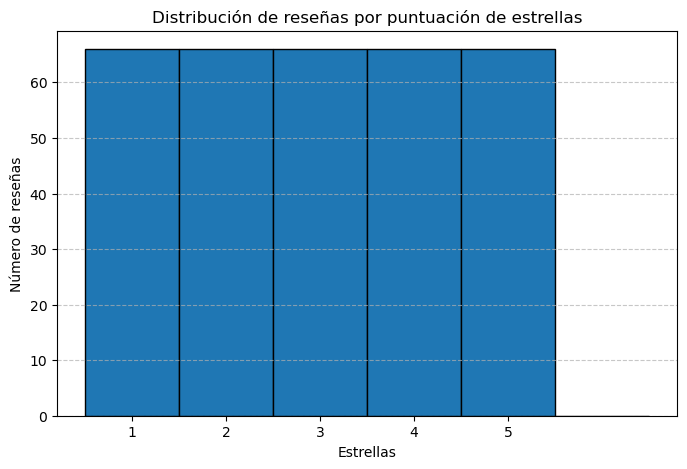

In [90]:
def distribucion_estrellas(y):
    # Crear histograma de la distribución de estrellas
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=range(1, 8), edgecolor='black', align='left')
    plt.xticks(range(1, 6))  # Ajustar ticks a las puntuaciones de 1 a 5
    plt.xlabel("Estrellas")
    plt.ylabel("Número de reseñas")
    plt.title("Distribución de reseñas por puntuación de estrellas")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    return

distribucion_estrellas(y_under)

In [91]:
def distancia_predicciones(y, y_pred):
    y = np.array(y)  
    y_pred = np.array(y_pred)

    # Crear índices con espaciado uniforme más grande
    x_indices = np.linspace(0, len(y) * 2.5, len(y))  # Factor 2.5 para mayor separación

    plt.figure(figsize=(12, 6))

    # Graficar la clase real vs la predicha con separación uniforme
    plt.scatter(x_indices, y, color="blue", label="Clase Real", marker="o", s=100)
    plt.scatter(x_indices, y_pred, color="red", label="Clase Predicha", marker="x", s=100)

    # Conectar con líneas para ver las diferencias
    for i in range(len(y)):
        plt.plot([x_indices[i], x_indices[i]], [y[i], y_pred[i]], color="gray", linestyle="--", alpha=0.6)

    plt.xlabel("Índice de Muestra (Separación Uniforme)")
    plt.ylabel("Clase")
    plt.title("Comparación entre Clases Reales y Predichas")
    plt.xticks([])  # Ocultar etiquetas en el eje X para evitar saturación visual
    plt.legend()
    plt.show()



# distancia_predicciones(y_true,y_pred)

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def distancia_predicciones_barras(y, y_pred):
    y = np.array(y)  
    y_pred = np.array(y_pred)
    
    # Calcular la diferencia entre la clase real y la predicha
    diferencia = y - y_pred  

    # Crear etiquetas para cada muestra
    indices = np.arange(len(y))

    plt.figure(figsize=(14, 7))

    # Barras para clase real
    plt.bar(indices, y, color='blue', alpha=0.6, label='Clase Real')

    # Barras para diferencia (positiva o negativa)
    plt.bar(indices, diferencia, color='red', alpha=0.6, label='Diferencia (Real - Predicha)', bottom=y)

    # Agregar valores en las barras
    for i in range(len(y)):
        plt.text(indices[i], y[i] + diferencia[i] / 2, f"{y_pred[i]}", ha='center', va='center', 
                 color="white", fontsize=12, fontweight="bold", bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2))

    # Expandir los límites del eje Y para evitar cortes
    plt.ylim(0, max(y) + 2)

    plt.xlabel("Índice de Muestra")
    plt.ylabel("Clase")
    plt.title("Diferencia entre Clases Reales y Predichas")
    plt.xticks(indices)  # Mostrar cada índice
    plt.yticks(range(1, max(y) + 2))  # Ajustar para las clases
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

# Ejemplo de uso con datos de prueba
y_true = np.array([5, 4, 3, 5, 2, 1, 4, 3, 5, 2])
y_pred = np.array([5, 3, 3, 4, 2, 1, 4, 2, 5, 3])

# distancia_predicciones_barras(y_true, y_pred)

# **ENTRENAMIENTO DEL MODELO**

[17 18 12 37 43]
El accuracy del clasificador  Naive-Bayes  es:  45.28


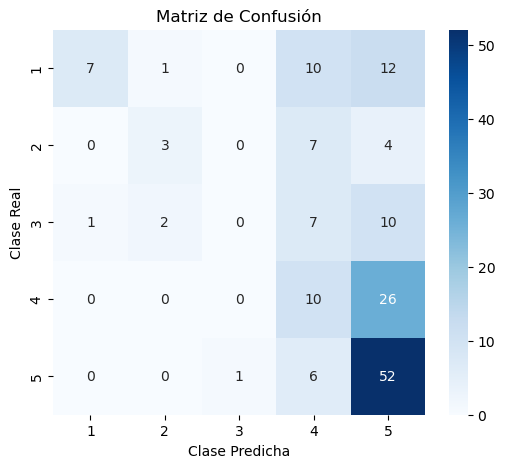

El accuracy del clasificador  SVC  es:  36.48


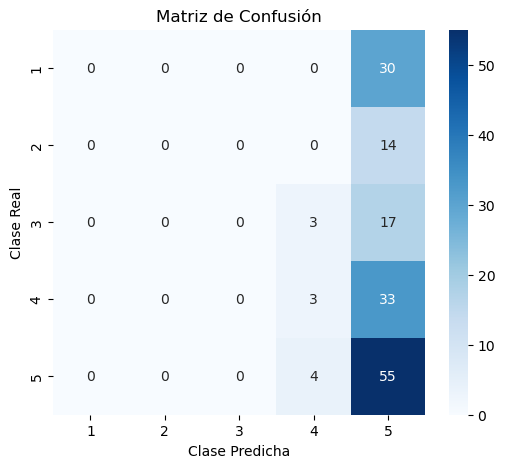

El accuracy del clasificador  LogisticRegression  es:  46.54


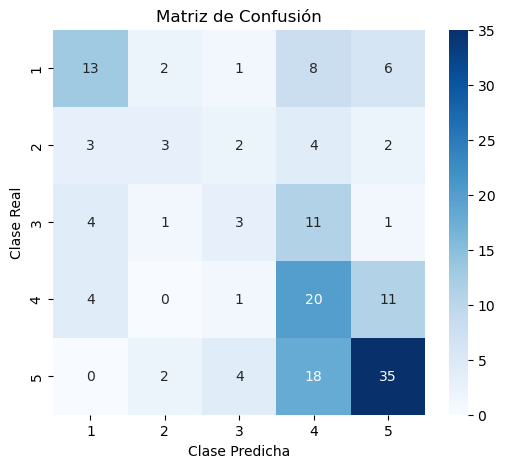

El accuracy del clasificador  DecisionTree  es:  33.96


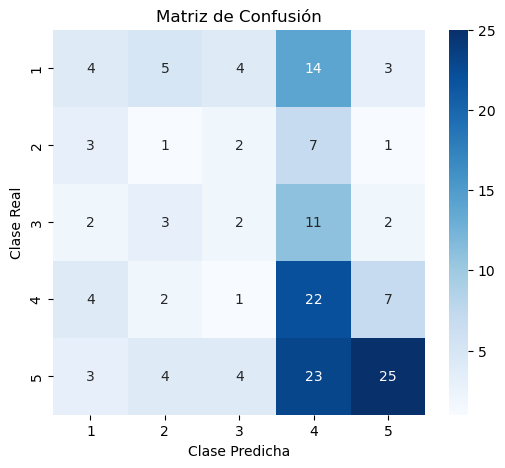

El accuracy del clasificador  Bagging  es:  39.62


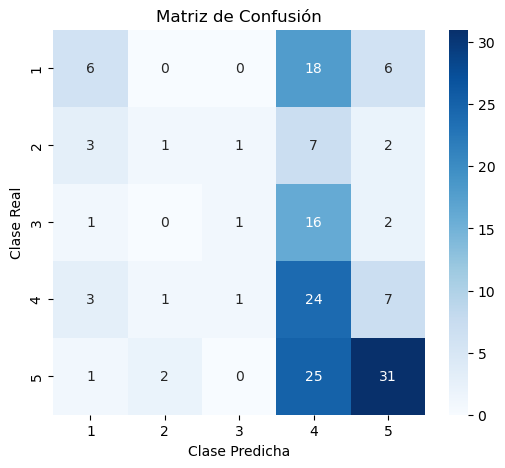

El accuracy del clasificador  Boosting  es:  43.4


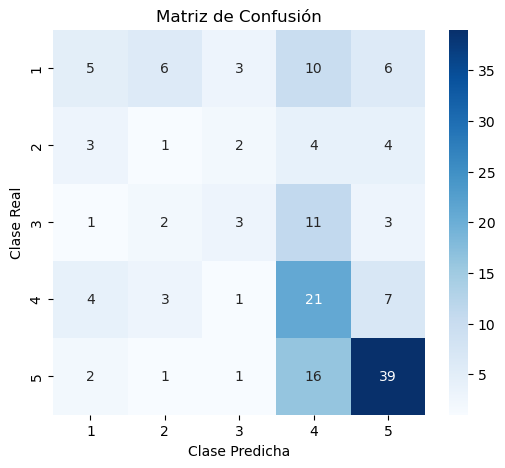

El accuracy del clasificador  RandomForest  es:  39.62


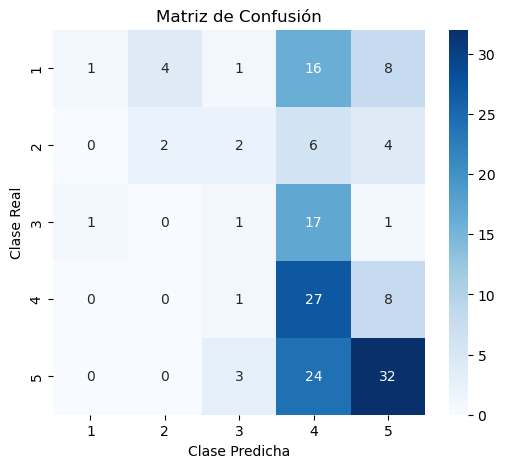

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#X_train, X_test, Y_train, Y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=12)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
oversampler = RandomOverSampler(random_state=42)
X_under_train, y_under_train = oversampler.fit_resample(X_train, Y_train)
X_under_test, y_under_test = oversampler.fit_resample(X_test, Y_test)
data_under = pd.concat([pd.DataFrame(X_under), pd.DataFrame(y_under, columns=["label"])], axis=1)


def entrenar_modelo(XTrain,XTest,YTrain,YTest):
    # class_counts = np.bincount(YTrain)  # Frecuencia de cada clase
    # class_counts = class_counts[1:]
    # class_prior = class_counts / np.sum(class_counts)  # Probabilidad de cada clase
    print(class_counts)
    clasificadores = [
        MultinomialNB(alpha = 2),
        SVC(random_state = 12),
        LogisticRegression(random_state=12,class_weight="balanced", C = 1),
        DecisionTreeClassifier(criterion='entropy', random_state=12),  # Árbol de decisión base
        BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=12),
                         n_estimators=15, random_state=12),  # Bagging
        AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=12),
                           n_estimators=15, random_state=12,algorithm = 'SAMME'),  # Boosting
        RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=12)  # Random Forest
    ]
    nombres = ['Naive-Bayes','SVC','LogisticRegression','DecisionTree', 'Bagging', 'Boosting', 'RandomForest']
    for i, clasificador in enumerate(clasificadores):
        #Entrenar modelo
        clasificador.fit(XTrain, YTrain)
        #Realizar prediccion
        y_test_pred = clasificador.predict(XTest)
        #Evaluar modelo
        acc = round(accuracy_score(YTest, y_test_pred)*100,2)
        print("El accuracy del clasificador ",nombres[i]," es: ",acc)
        matriz_confusion(YTest,y_test_pred)
        # mascara = YTest==5
        # ytest_5 = YTest[mascara]
        # y_pred_5 = y_test_pred[mascara]
        # y_pred_5 = 5 * np.ones(y_pred_5.shape)
        # distancia_predicciones(ytest_5,y_pred_5)
    return acc

acc = entrenar_modelo(X_val,X_test,Y_val,Y_test)
#acc = entrenar_modelo(X_under_train,X_under_test,y_under_train,y_under_test)

In [94]:

# Entrenar modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
modelo_lr.fit(X_train, Y_train)

# Obtener coeficientes de importancia
coeficientes = modelo_lr.coef_  # (n_clases, n_palabras)

# Obtener vocabulario
vocabulario = vectorizer.get_feature_names_out()

# Mostrar las palabras más influyentes por clase
for i, estrellas in enumerate(modelo_lr.classes_):
    top_indices = np.argsort(coeficientes[i])[-15:]  # Tomamos las 15 palabras más importantes
    palabras_top = [vocabulario[idx] for idx in top_indices]
    coef_top = [coeficientes[i, idx] for idx in top_indices]

    print(f"\n🔹 Palabras más influyentes para {estrellas} estrellas:")
    for palabra, coef in zip(palabras_top, coef_top):
        print(f"{palabra} (score: {coef:.4f})")



🔹 Palabras más influyentes para 1 estrellas:
durado (score: 0.5433)
probarlos (score: 0.5809)
lido (score: 0.5815)
tampoco (score: 0.5922)
micr (score: 0.5935)
rotos (score: 0.5935)
baja (score: 0.6593)
pegado (score: 0.6594)
hace (score: 0.6760)
fono_no (score: 0.7339)
no_funciona (score: 0.7472)
dejado (score: 0.8939)
almohadillas (score: 0.8974)
devuelto (score: 0.9988)
funcionar (score: 1.0392)

🔹 Palabras más influyentes para 2 estrellas:
do (score: 0.7426)
no_le (score: 0.7655)
durado (score: 0.7821)
no_toca (score: 0.7868)
no_se (score: 0.7879)
regular (score: 0.8310)
gustaron (score: 0.8470)
microo (score: 0.8627)
devolverlo (score: 0.8627)
flojo (score: 0.8752)
fono (score: 0.8914)
romperse (score: 0.8992)
microfono (score: 0.9159)
escuchan (score: 0.9634)
mal (score: 1.3064)

🔹 Palabras más influyentes para 3 estrellas:
mundo (score: 0.6486)
regulera (score: 0.6544)
no_me (score: 0.6617)
alguien (score: 0.6791)
duro (score: 0.6998)
pereci (score: 0.7126)
poca (score: 0.7148)

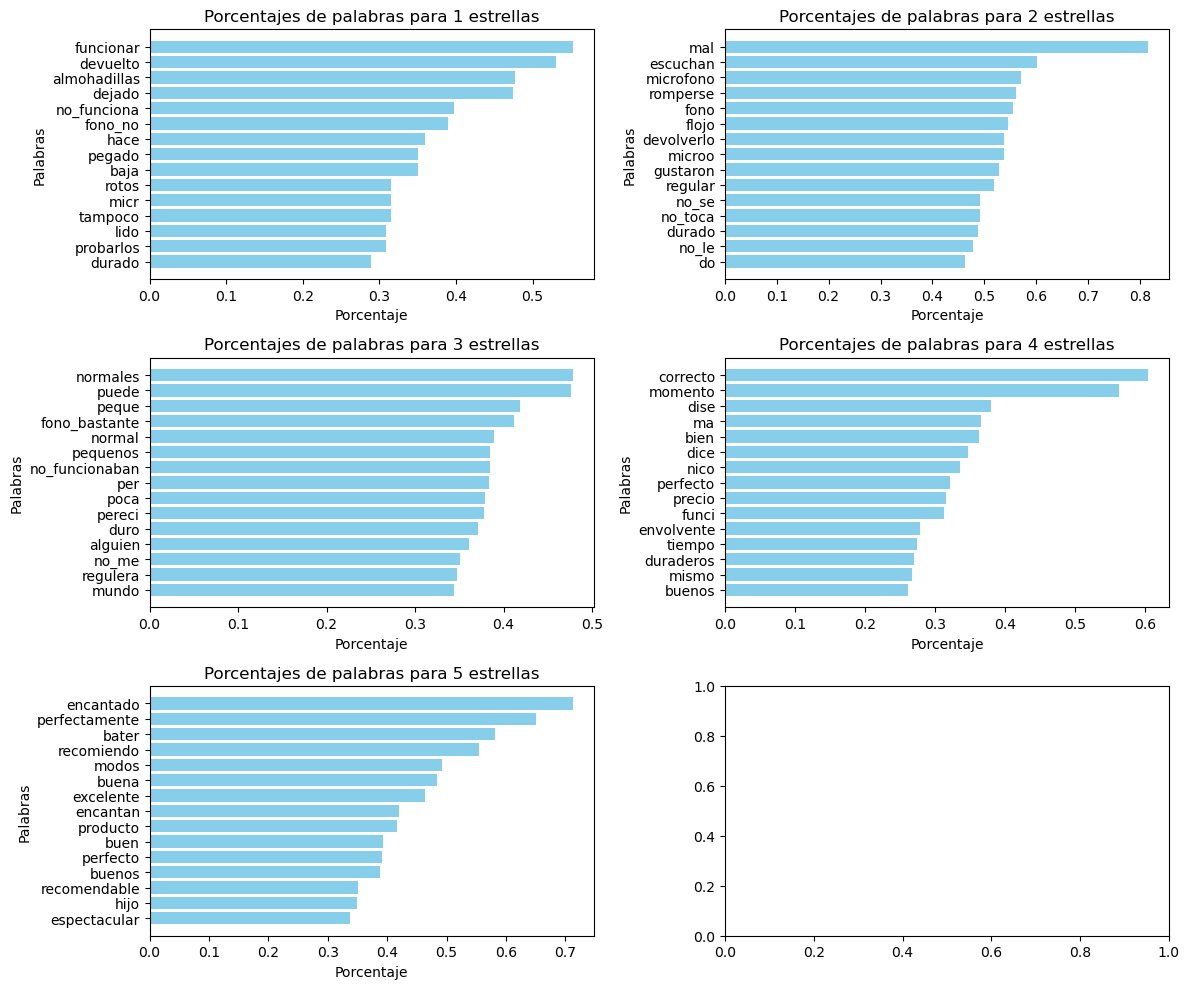

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Entrenar modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
modelo_lr.fit(X_train, Y_train)

# Obtener coeficientes de importancia
coeficientes = modelo_lr.coef_  # (n_clases, n_palabras)

# Obtener vocabulario
vocabulario = vectorizer.get_feature_names_out()

# Inicializar una lista para guardar los porcentajes
porcentajes_por_clase = []

# Calcular los porcentajes de cada palabra para cada clase
for i, estrellas in enumerate(modelo_lr.classes_):
    coef_class = coeficientes[i]
    total_coef = np.sum(np.abs(coef_class))  # Sumamos los coeficientes absolutos de la clase
    porcentajes = (np.abs(coef_class) / total_coef) * 100  # Convertimos en porcentaje
    
    # Guardamos los porcentajes junto con las palabras
    top_indices = np.argsort(coef_class)[-15:]  # Tomamos las 15 palabras más importantes
    palabras_top = [vocabulario[idx] for idx in top_indices]
    porcentajes_top = [porcentajes[idx] for idx in top_indices]
    
    porcentajes_por_clase.append((palabras_top, porcentajes_top))

# Crear una cuadrícula de subgráficas (3 filas, 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # Tamaño reducido
axes = axes.flatten()

# Crear un gráfico por clase de estrellas
for i, (palabras_top, porcentajes_top) in enumerate(porcentajes_por_clase):
    ax = axes[i]  # Acceder a cada subgráfico
    ax.barh(palabras_top, porcentajes_top, color='skyblue')
    ax.set_title(f'Porcentajes de palabras para {modelo_lr.classes_[i]} estrellas')
    ax.set_xlabel('Porcentaje')
    ax.set_ylabel('Palabras')

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()
